<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pandas,sklearn,mlxtend

last updated: 2017-07-06 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
scipy 0.19.0
pandas 0.20.1
sklearn 0.18.1
mlxtend 0.6.0


# Data-MC comparison
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Weight simulation events to spectrum](#Weight-simulation-events-to-spectrum)
3. [S125 verification](#S125-verification)
4. [$\log_{10}(\mathrm{dE/dX})$ verification](#$\log_{10}(\mathrm{dE/dX})$-verification)

In [2]:
from __future__ import division, print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from icecube.weighting.weighting import from_simprod
from icecube import dataclasses

import comptools as comp
import comptools.analysis.plotting as plotting

color_dict = comp.analysis.get_color_dict()

%matplotlib inline

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature selection

### Load simulation, format feature and target matrices

In [6]:
config = 'IC86.2012'
# comp_list = ['light', 'heavy']
comp_list = ['PPlus', 'Fe56Nucleus']
june_july_data_only = False

In [4]:
sim_df = comp.load_dataframe(datatype='sim', config=config, split=False)
data_df = comp.load_dataframe(datatype='data', config=config)

Starting out with 108522 sim events
sim quality cut event flow:
      passed_IceTopQualityCuts:    1.0    1.0
FractionContainment_Laputop_InIce:  0.793  0.793
       passed_InIceQualityCuts:  0.795   0.76
                 num_hits_1_60:  0.997  0.759
             reco_energy_range:  0.874  0.662


Starting out with 8020592 data events
data quality cut event flow:
      passed_IceTopQualityCuts:    1.0    1.0
FractionContainment_Laputop_InIce:    1.0    1.0
       passed_InIceQualityCuts:  0.918  0.918
                 num_hits_1_60:    1.0  0.918
             reco_energy_range:    1.0  0.918




/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:133: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])


In [5]:
data_df = data_df[np.isfinite(data_df['log_dEdX'])]

In [7]:
if june_july_data_only:
    
    print('Masking out all data events not in June or July')
    
    def is_june_july(time):
        i3_time = dataclasses.I3Time(time)
        return i3_time.date_time.month in [6, 7]

    june_july_mask = data_df.end_time_mjd.apply(is_june_july)
    data_df = data_df[june_july_mask].reset_index(drop=True)

In [8]:
months = (6, 7) if june_july_data_only else None
livetime, livetime_err = comp.get_detector_livetime(config, months=months)

# Weight simulation events to spectrum 

[ [back to top](#top) ]

For more information, see the [IT73-IC79 Data-MC comparison wiki page](https://wiki.icecube.wisc.edu/index.php/IT73-IC79_Data-MC_Comparison).

First, we'll need to define a 'realistic' flux model

In [9]:
phi_0 = 3.5e-6
# phi_0 = 2.95e-6
gamma_1 = -2.7
gamma_2 = -3.1
eps = 100
def flux(E):
    E = np.array(E) * 1e-6 
    return (1e-6) * phi_0 * E**gamma_1 *(1+(E/3.)**eps)**((gamma_2-gamma_1)/eps)

In [10]:
from icecube.weighting.weighting import PowerLaw

In [11]:
pl_flux = PowerLaw(eslope=-2.7, emin=1e5, emax=3e6, nevents=1e6) + \
          PowerLaw(eslope=-3.1, emin=3e6, emax=1e10, nevents=1e2)

In [12]:
pl_flux.spectra

defaultdict(list,
            {None: [PowerLaw(-2.70, emin=1.00e+05, emax=3.00e+06, nevents=1.00e+06),
              PowerLaw(-3.10, emin=3.00e+06, emax=1.00e+10, nevents=1.00e+02)]})

In [13]:
from icecube.weighting.fluxes import GaisserH3a, GaisserH4a, Hoerandel5
flux_h4a = GaisserH4a()

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


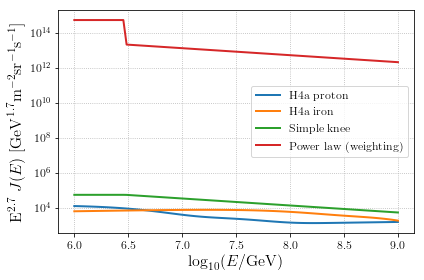

In [14]:
energy_points = np.logspace(6.0, 9.0, 100)
fig, ax = plt.subplots()
ax.plot(np.log10(energy_points), energy_points**2.7*flux_h4a(energy_points, 2212),
       marker='None', ls='-', lw=2, label='H4a proton')
ax.plot(np.log10(energy_points), energy_points**2.7*flux_h4a(energy_points, 1000260560),
       marker='None', ls='-', lw=2, label='H4a iron')
ax.plot(np.log10(energy_points), energy_points**2.7*flux(energy_points),
       marker='None', ls='-', lw=2, label='Simple knee')
ax.plot(np.log10(energy_points), energy_points**2.7*pl_flux(energy_points),
       marker='None', ls='-', lw=2, label='Power law (weighting)')
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\log_{10}(E/\mathrm{GeV})$')
ax.set_ylabel('$\mathrm{E}^{2.7} \ J(E) \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.grid(which='both')
ax.legend()
plt.show()

In [15]:
simlist = np.unique(sim_df['sim'])
for i, sim in enumerate(simlist):
    gcd_file, sim_files = comp.simfunctions.get_level3_sim_files(sim)
    num_files = len(sim_files)
    print('Simulation set {}: {} files'.format(sim, num_files))
    if i == 0:
        generator = num_files*from_simprod(int(sim))
    else:
        generator += num_files*from_simprod(int(sim))
energy = sim_df['MC_energy'].values
ptype = sim_df['MC_type'].values
num_ptypes = np.unique(ptype).size
cos_theta = np.cos(sim_df['MC_zenith']).values
weights = 1.0/generator(energy, ptype, cos_theta)
# weights = weights/num_ptypes

Simulation set 12360: 19781 files
Simulation set 12362: 19808 files
Simulation set 12630: 19787 files
Simulation set 12631: 19834 files


In [16]:
sim_df['weights'] = flux(sim_df['MC_energy'])*weights
# sim_df['weights'] = flux_h4a(sim_df['MC_energy'], sim_df['MC_type'])*weights

In [17]:
MC_comp_mask = {}
for composition in comp_list:
    MC_comp_mask[composition] = sim_df['MC_comp'] == composition
#     MC_comp_mask[composition] = sim_df['MC_comp_class'] == composition

In [18]:
def plot_rate(array, weights, bins, xlabel=None, color='C0',
              label=None, legend=True, alpha=0.8, ax=None):
    
    if ax is None:
        ax = plt.gca()

    rate = np.histogram(array, bins=bins, weights=weights)[0]
    rate_err = np.sqrt(np.histogram(array, bins=bins, weights=weights**2)[0])
    plotting.plot_steps(bins, rate, yerr=rate_err, color=color,
                        label=label, alpha=alpha, ax=ax)
    ax.set_yscale('log', nonposy='clip')
    ax.set_ylabel('Rate [Hz]')
    if xlabel:
        ax.set_xlabel(xlabel)
    if legend:
        ax.legend()
    ax.grid(True)
    
    return ax

In [19]:
def plot_data_MC_ratio(sim_array, sim_weights, data_array, data_weights, bins,
                       xlabel=None, color='C0', alpha=0.8, label=None,
                       legend=False, ylim=None, ax=None):
    
    if ax is None:
        ax = plt.gca()

    sim_rate = np.histogram(sim_array, bins=bins, weights=sim_weights)[0]
    sim_rate_err = np.sqrt(np.histogram(sim_array, bins=bins, weights=sim_weights**2)[0])
    
    data_rate = np.histogram(data_array, bins=bins, weights=data_weights)[0]
    data_rate_err = np.sqrt(np.histogram(data_array, bins=bins, weights=data_weights**2)[0])
    
    ratio, ratio_err = comp.analysis.ratio_error(data_rate, data_rate_err, sim_rate, sim_rate_err)
    
    plotting.plot_steps(bins, ratio, yerr=ratio_err,
                        color=color, label=label, alpha=alpha, ax=ax)
    ax.grid(True)
    ax.set_ylabel('Data/MC')
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylim:
        ax.set_ylim(ylim)
    if legend:
        ax.legend()

    ax.axhline(1, marker='None', ls='-.', color='k')
    
    return ax

## $\log_{10}(\mathrm{S_{125}})$ verification

[ [back to top](#top) ]

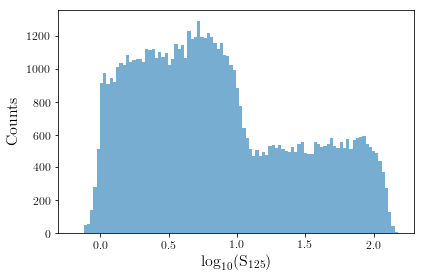

In [20]:
sim_df['log_s125'].plot(kind='hist', bins=100, alpha=0.6, lw=1.5)
plt.xlabel('$\log_{10}(\mathrm{S}_{125})$')
plt.ylabel('Counts');

/home/jbourbeau/cr-composition/comptools/analysis/data_functions.py:10: RuntimeWarning: divide by zero encountered in true_divide
  ratio = num/den
/home/jbourbeau/cr-composition/comptools/analysis/data_functions.py:10: RuntimeWarning: invalid value encountered in true_divide
  ratio = num/den
/home/jbourbeau/cr-composition/comptools/analysis/data_functions.py:11: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = ratio * np.sqrt((num_err / num)**2 + (den_err / den)**2)


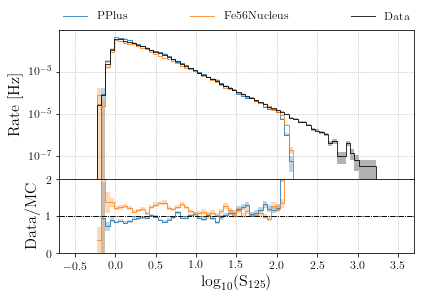

In [21]:
log_s125_bins = np.linspace(-0.5, 3.5, 75)

gs = gridspec.GridSpec(2, 1, height_ratios=[2,1], hspace=0.0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
for composition in comp_list:
    sim_s125 = sim_df[MC_comp_mask[composition]]['log_s125']
    sim_weights = sim_df[MC_comp_mask[composition]]['weights']
    plot_rate(sim_s125, sim_weights, bins=log_s125_bins,
              color=color_dict[composition], label=composition, ax=ax1)
data_weights = np.array([1/livetime]*len(data_df['log_s125']))
plot_rate(data_df['log_s125'], data_weights, bins=log_s125_bins,
          color=color_dict['data'], label='Data', ax=ax1)

for composition in comp_list:
    sim_s125 = sim_df[MC_comp_mask[composition]]['log_s125']
    sim_weights = sim_df[MC_comp_mask[composition]]['weights']
    ax2 = plot_data_MC_ratio(sim_s125, sim_weights, 
                       data_df['log_s125'], data_weights, log_s125_bins,
                       xlabel='$\log_{10}(\mathrm{S}_{125})$', color=color_dict[composition],
                       label=composition, ax=ax2)
    ax2.set_ylim((0, 2))
    
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0., frameon=False)

plt.savefig(os.path.join(comp.paths.figures_dir, 'data-MC-comparison', 's125.png'))
plt.show()

##  $\log_{10}(\mathrm{dE/dX})$ verification

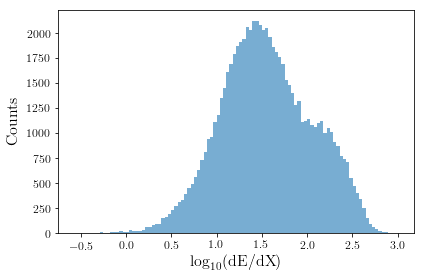

In [47]:
sim_df['log_dEdX'].plot(kind='hist', bins=100, alpha=0.6, lw=1.5)
plt.xlabel('$\log_{10}(\mathrm{dE/dX})$')
plt.ylabel('Counts');

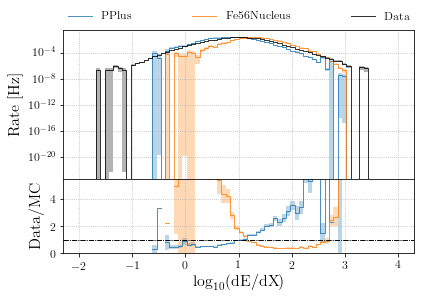

In [60]:
log_dEdX_bins = np.linspace(-2, 4, 75)

gs = gridspec.GridSpec(2, 1, height_ratios=[2,1], hspace=0.0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
for composition in comp_list:
    sim_dEdX = sim_df[MC_comp_mask[composition]]['log_dEdX']
    sim_weights = sim_df[MC_comp_mask[composition]]['weights']
    plot_rate(sim_dEdX, sim_weights, bins=log_dEdX_bins,
              color=color_dict[composition], label=composition, ax=ax1)
data_weights = np.array([1/livetime]*len(data_df))
plot_rate(data_df['log_dEdX'], data_weights, bins=log_dEdX_bins,
          color=color_dict['data'], label='Data', ax=ax1)

for composition in comp_list:
    sim_dEdX = sim_df[MC_comp_mask[composition]]['log_dEdX']
    sim_weights = sim_df[MC_comp_mask[composition]]['weights']
    ax2 = plot_data_MC_ratio(sim_dEdX, sim_weights,
                       data_df['log_dEdX'], data_weights, log_dEdX_bins,
                       xlabel='$\log_{10}(\mathrm{dE/dX})$', color=color_dict[composition],
                       label=composition, ylim=[0, 5.5], ax=ax2)
    
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0., frameon=False)

plt.savefig(os.path.join(comp.paths.figures_dir, 'data-MC-comparison', 'dEdX.png'))
plt.show()

## $\cos(\theta)$ verification

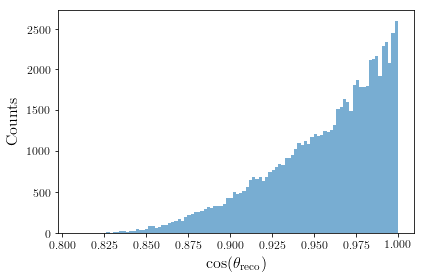

In [49]:
sim_df['lap_cos_zenith'].plot(kind='hist', bins=100, alpha=0.6, lw=1.5)
plt.xlabel('$\cos(\\theta_{\mathrm{reco}})$')
plt.ylabel('Counts');

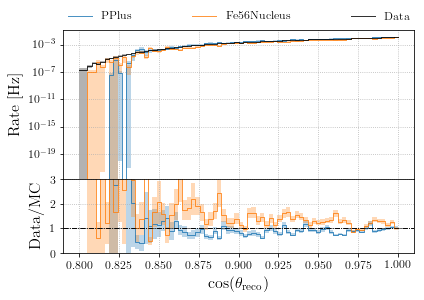

In [55]:
cos_zenith_bins = np.linspace(0.8, 1.0, 75)

gs = gridspec.GridSpec(2, 1, height_ratios=[2,1], hspace=0.0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
for composition in comp_list:
    sim_cos_zenith = sim_df[MC_comp_mask[composition]]['lap_cos_zenith']
    sim_weights = sim_df[MC_comp_mask[composition]]['weights']
    plot_rate(sim_cos_zenith, sim_weights, bins=cos_zenith_bins,
              color=color_dict[composition], label=composition, ax=ax1)
data_weights = np.array([1/livetime]*len(data_df))
plot_rate(data_df['lap_cos_zenith'], data_weights, bins=cos_zenith_bins,
          color=color_dict['data'], label='Data', ax=ax1)

for composition in comp_list:
    sim_cos_zenith = sim_df[MC_comp_mask[composition]]['lap_cos_zenith']
    sim_weights = sim_df[MC_comp_mask[composition]]['weights']
    ax2 = plot_data_MC_ratio(sim_cos_zenith, sim_weights,
                       data_df['lap_cos_zenith'], data_weights, cos_zenith_bins,
                       xlabel='$\cos(\\theta_{\mathrm{reco}})$', color=color_dict[composition],
                       label=composition, ylim=[0, 3], ax=ax2)
    
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0., frameon=False)

plt.savefig(os.path.join(comp.paths.figures_dir, 'data-MC-comparison', 'zenith.png'))
plt.show()

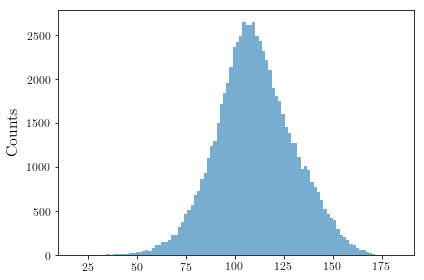

In [24]:
sim_df['avg_inice_radius'].plot(kind='hist', bins=100, alpha=0.6, lw=1.5)
# plt.xlabel('$\cos(\\theta_{\mathrm{reco}})$')
plt.ylabel('Counts');

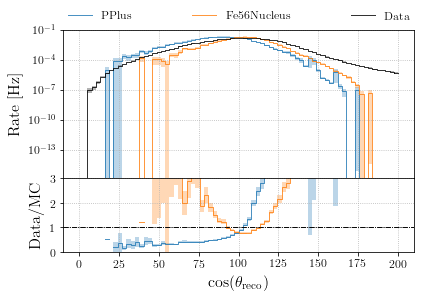

In [26]:
inice_radius_bins = np.linspace(0.0, 200, 75)

gs = gridspec.GridSpec(2, 1, height_ratios=[2,1], hspace=0.0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
for composition in comp_list:
    sim_inice_radius = sim_df[MC_comp_mask[composition]]['avg_inice_radius']
    sim_weights = sim_df[MC_comp_mask[composition]]['weights']
    plot_rate(sim_inice_radius, sim_weights, bins=inice_radius_bins,
              color=color_dict[composition], label=composition, ax=ax1)
data_weights = np.array([1/livetime]*len(data_df))
plot_rate(data_df['avg_inice_radius'], data_weights, bins=inice_radius_bins,
          color=color_dict['data'], label='Data', ax=ax1)

for composition in comp_list:
    sim_inice_radius = sim_df[MC_comp_mask[composition]]['avg_inice_radius']
    sim_weights = sim_df[MC_comp_mask[composition]]['weights']
    ax2 = plot_data_MC_ratio(sim_inice_radius, sim_weights,
                       data_df['avg_inice_radius'], data_weights, inice_radius_bins,
                       xlabel='$\cos(\\theta_{\mathrm{reco}})$', color=color_dict[composition],
                       label=composition, ylim=[0, 3], ax=ax2)
    
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0., frameon=False)

# plt.savefig(os.path.join(comp.paths.figures_dir, 'data-MC-comparison', 'zenith.png'))
plt.show()

In [27]:
sim_df.columns

Index([u'FractionContainment_Laputop_IceTop',
       u'FractionContainment_Laputop_InIce',
       u'FractionContainment_MCPrimary_IceTop',
       u'FractionContainment_MCPrimary_InIce', u'IceTopMaxSignal',
       u'IceTopMaxSignalInEdge', u'IceTopMaxSignalString',
       u'IceTopNeighbourMaxSignal', u'InIce_charge_1_60', u'MC_azimuth',
       u'MC_comp', u'MC_comp_class', u'MC_energy', u'MC_type', u'MC_x',
       u'MC_y', u'MC_zenith', u'NChannels_1_60', u'NHits_1_60', u'NStations',
       u'StationDensity', u'angle_MCPrimary_Laputop', u'avg_inice_radius',
       u'eloss_1500_standard', u'end_time_mjd',
       u'frac_outside_one_std_inice_radius',
       u'frac_outside_two_std_inice_radius', u'lap_azimuth', u'lap_beta',
       u'lap_chi2', u'lap_energy', u'lap_fitstatus_ok', u'lap_ndf',
       u'lap_rlogl', u'lap_s125', u'lap_s180', u'lap_s250', u'lap_s50',
       u'lap_s500', u'lap_s80', u'lap_x', u'lap_y', u'lap_zenith',
       u'max_qfrac_1_60', u'mil_qtot_measured', u'mil_qtot_pred